# Augur for Influenza A - HA protein

## Import packages

In [304]:
from Bio import Phylo
import matplotlib
import matplotlib.pyplot as plt
from Bio import SeqIO
from Bio.Seq import translate
import re
import pandas as pd
import json
from plotnine import *
import itertools
from scipy.special import comb
import numpy as np
from scipy.stats import kde

## Configuration variables

In [33]:
subsample = 5
print("test for %s" %subsample)

test for 5


## Create Metadata file 

In [18]:
records = []
for record in SeqIO.parse("../data/fluHA_sequences-with-metadata.fasta", "fasta"):
    records.append(record.description)

    
# Split description
split = []
for record in records:
    split.append(record.split('|'))

# Grab metadata from split description    
strainsList = []
idList = []
dateUnsplit = []
countryList = []
stateList = []
for item in split:
    strainsList.append(item[0])
    idList.append(item[1])
    dateUnsplit.append(item[2])
    countryList.append(item[3])
    stateList.append(item[4])

### Get dates from fasta.description

In [19]:
# Get dates
dateSearch = re.compile('(?P<month>\d{2})[/](?P<day>\d{2})[/](?P<year>\d{4}$)')
yearSearch = re.compile('(?P<year>\d{4}$)')
monthYearSearch = re.compile('(?P<month>\d{2})[/](?P<year>\d{4}$)')
monthList = []
dayList = []
yearList = []
for item in dateUnsplit:
    if len(item) == 4:
        y = yearSearch.search(item)
        year = y.group('year')
        yearList.append(year)
        monthList.append('XX')
        dayList.append('XX')
    elif len(item) == 10:
        d = dateSearch.search(item)
        month = d.group('month')
        day = d.group('day')
        year = d.group('year')
    
        monthList.append(month)
        dayList.append(day)
        yearList.append(year)
    elif len(item) == 7:
        d = monthYearSearch.search(item)
        month = d.group('month')
        year = d.group('year')
    
        monthList.append(month)
        dayList.append("XX")
        yearList.append(year)

        
# If year < 1957 add 19 years
index = 0
for year in yearList:
    if int(year) < 1976:
        yearList[index] = str(int(year) + 23)
    index += 1
        
dateList = []
index = 0
for i in range(len(dateUnsplit)):
    dateList.append(yearList[i] + '-' + monthList[i] + '-' + dayList[i])
    index += 1

### Combine ID and strains to create unique identifiers

In [20]:
# Concatenate strain strings with id strings for unique identifiers
newID = []
counter = 0
for id in idList:
    newID.append(id + "|" + strainsList[counter])
    
#     Remove spaces
#     if " " in newID[counter]:
#         newID[counter] = newID[counter].replace(" ", "")
#     counter += 1

# Remove apostrophes
    if "'" in newID[counter]:
        newID[counter] = newID[counter].replace("'", "")
    counter += 1



### Create new fasta file to replace IDs with the new ones

In [25]:
original_file = r"../data/fluHA_sequences-with-metadata.fasta"
corrected_file = r"../data/corrected2.fasta"

position = 0
with open(original_file) as original, open(corrected_file, 'w') as corrected:
    records = SeqIO.parse(original_file, 'fasta')
    for record in records:
#         print(record.id)
        record.id = newID[position]
        record.description = newID[position]
        position += 1
#         print(record.id)             
        SeqIO.write(record, corrected, 'fasta')

### Write metadata.tsv file

In [20]:
# metadata_id = list(zip(fasta_ids, strainsList, yearsList))
# metadata = list(zip(idList, strainsList, yearsList))
metadata = list(zip(newID, dateList))

# df = pd.DataFrame(data = metadata, columns=['id', 'strain', 'year'])
df = pd.DataFrame(data = metadata, columns=['strain', 'date'])

df.to_csv('../data/metadata.tsv',sep='\t',index=False,header=True)

## Tree with 5 sequences per group
### Filter

In [14]:
!mkdir -p ../results/

!augur filter \
  --sequences ../data/corrected.fasta \
  --metadata ../data/metadata.tsv \
  --exclude ../config/dropped_strains.txt \
  --output ../results/filtered-5.fasta \
  --group-by year \
  --sequences-per-group 5 \
  --min-date 1918

### Align

In [15]:
!augur align \
  --sequences ../results/filtered-5.fasta \
  --output ../results/aligned-5.fasta 


using mafft to align via:
	mafft --reorder --anysymbol --thread 1 ../results/filtered-5.fasta 1> ../results/aligned-5.fasta 2> ../results/aligned-5.fasta.log 

	Katoh et al, Nucleic Acid Research, vol 30, issue 14
	https://doi.org/10.1093%2Fnar%2Fgkf436



Tree takes 2.04 seconds to build

### Tree

#### Remove putative frameshifted alignments
**NOTE**: strain 'CY020461|A/Iowa/1943', "CY125196|A/Canada/591/2004", "CY146769|A/Bellamy/JY2/1942", "FJ231763|A/Bremen/4/2005" because they look like there may have been a frameshift in the sequences when they were aligned. Bio.Seq's translate function read "C---" as "C--" and got confused 

**NOTE**: "DQ889689|A/Iowa/CEID23/2005" is a swine flu-looking strain. I'm removing it here so that I don't have to re-`filter`

In [108]:
# original_file = r"../results/gabe_alignment.fasta"
# removed_file = r"../results/aligned-5_removed.fasta"
# remove_list = ["DQ889689|A/Iowa/CEID23/2005", 'CY020461|A/Iowa/1943', "CY125862|A/Kw/1/1957", "CY146793|A/Denver/JY2/1957", "HE802059|A/WSN/1933" ]
# remove_list = ["DQ889689|A/Iowa/CEID23/2005"]

# with open(original_file) as original, open(removed_file, 'w') as removed:
#     records = SeqIO.parse(original_file, 'fasta')
#     for record in records:
#         if record.id not in remove_list:          
#             SeqIO.write(record, removed, 'fasta')
            



In [109]:
!augur tree \
  --alignment ../results/gabe_alignment.fasta \
  --output ../results/tree_raw-5_removed.nwk

Building a tree via:
	iqtree -ninit 2 -n 2 -me 0.05 -nt 1 -s ../results/aligned-5_removed-delim.fasta -m GTR > ../results/aligned-5_removed-delim.iqtree.log
	Nguyen et al: IQ-TREE: A fast and effective stochastic algorithm for estimating maximum likelihood phylogenies.
	Mol. Biol. Evol., 32:268-274. https://doi.org/10.1093/molbev/msu300

Building original tree took 1.0771067142486572 seconds


### View

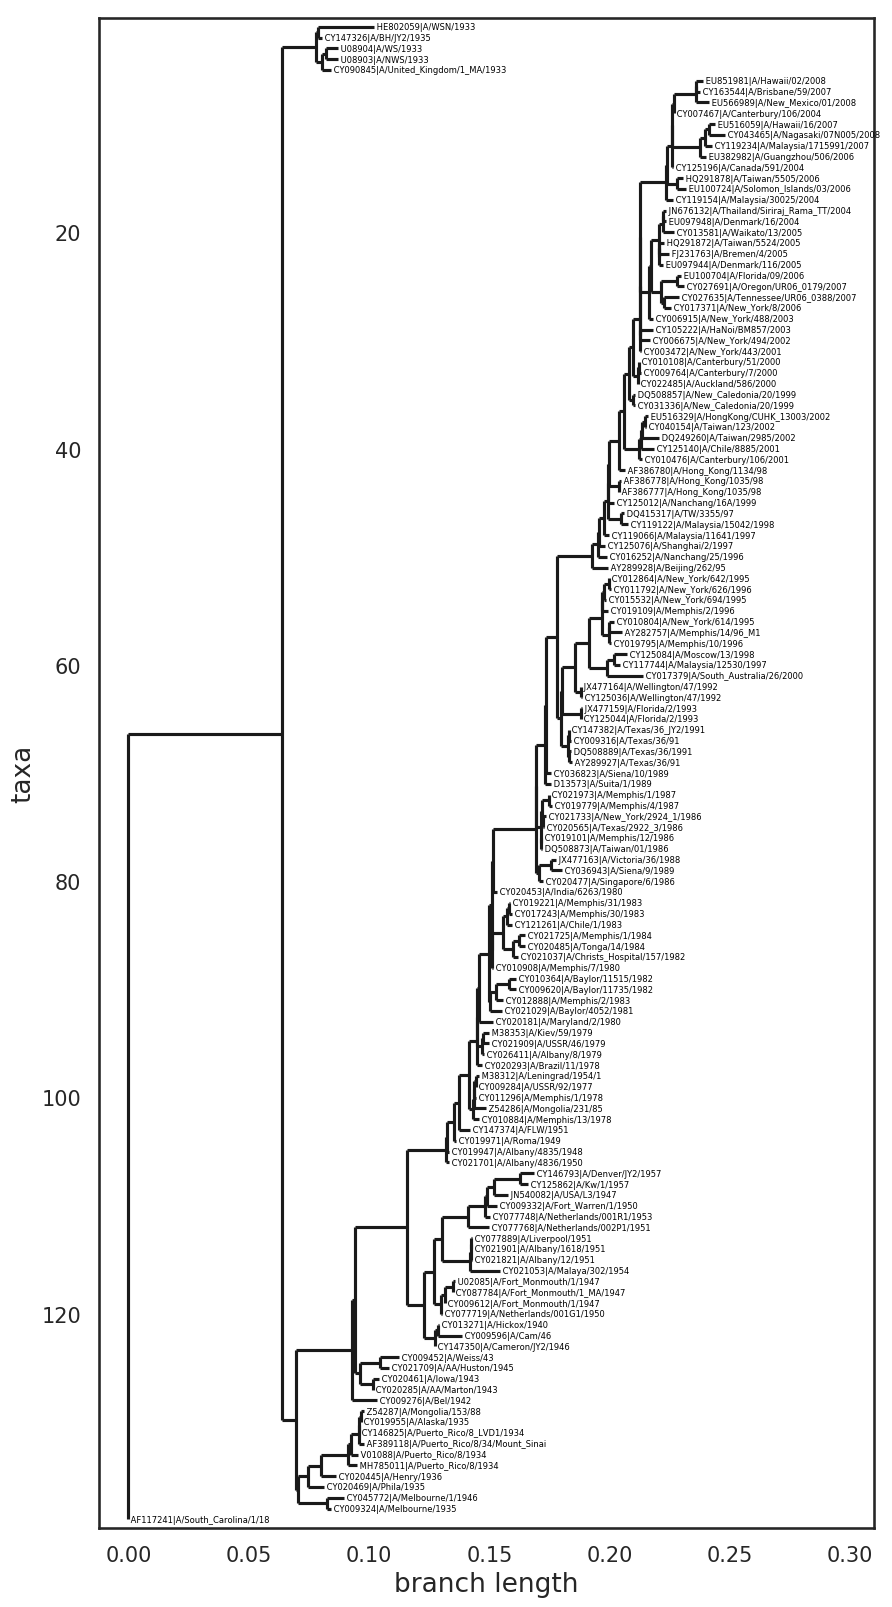

None


In [110]:
tree = Phylo.read("../results/tree_raw-5_removed.nwk", "newick")
matplotlib.rc('font',size=6)
fig = plt.figure(figsize=(10,20), dpi=100)
axes=fig.add_subplot(1, 1, 1)
tree.ladderize(reverse=True)
tree.root_with_outgroup(outgroup_targets="AF117241|A/South_Carolina/1/18")
print(Phylo.draw(tree, axes=axes))

### Count tips

Same number of tips as sequences

In [35]:
tree.count_terminals()

168

In [38]:
seqCount = []
for record in SeqIO.parse("../results/aligned-5_removed.fasta", "fasta"):
    seqCount.append(record.seq)

print(len(seqCount))

168


## Get time-resolved tree
### Augur refine

In [111]:
!augur refine \
  --tree ../results/tree_raw-5_removed.nwk \
  --alignment ../results/aligned-5_removed.fasta \
  --metadata ../data/metadata.tsv \
  --output-tree ../results/tree-5_removed.nwk \
  --output-node-data ../results/branch_lengths-5_removed.json \
  --timetree \
  --coalescent opt \
  --date-confidence \
  --date-inference joint
#   --clock-filter-iqd 4


7.16	###TreeTime.run: INITIAL ROUND

30.63	###TreeTime.run: ITERATION 1 out of 2 iterations

60.70	###TreeTime.run: ITERATION 2 out of 2 iterations

189.61	###TreeTime.run: FINAL ROUND - confidence estimation via marginal reconstruction

Inferred a time resolved phylogeny using TreeTime:
	Sagulenko et al. TreeTime: Maximum-likelihood phylodynamic analysis
	Virus Evolution, vol 4, https://academic.oup.com/ve/article/4/1/vex042/4794731

updated tree written to ../results/tree-5_removed.nwk
node attributes written to ../results/branch_lengths-5_removed.json


### View

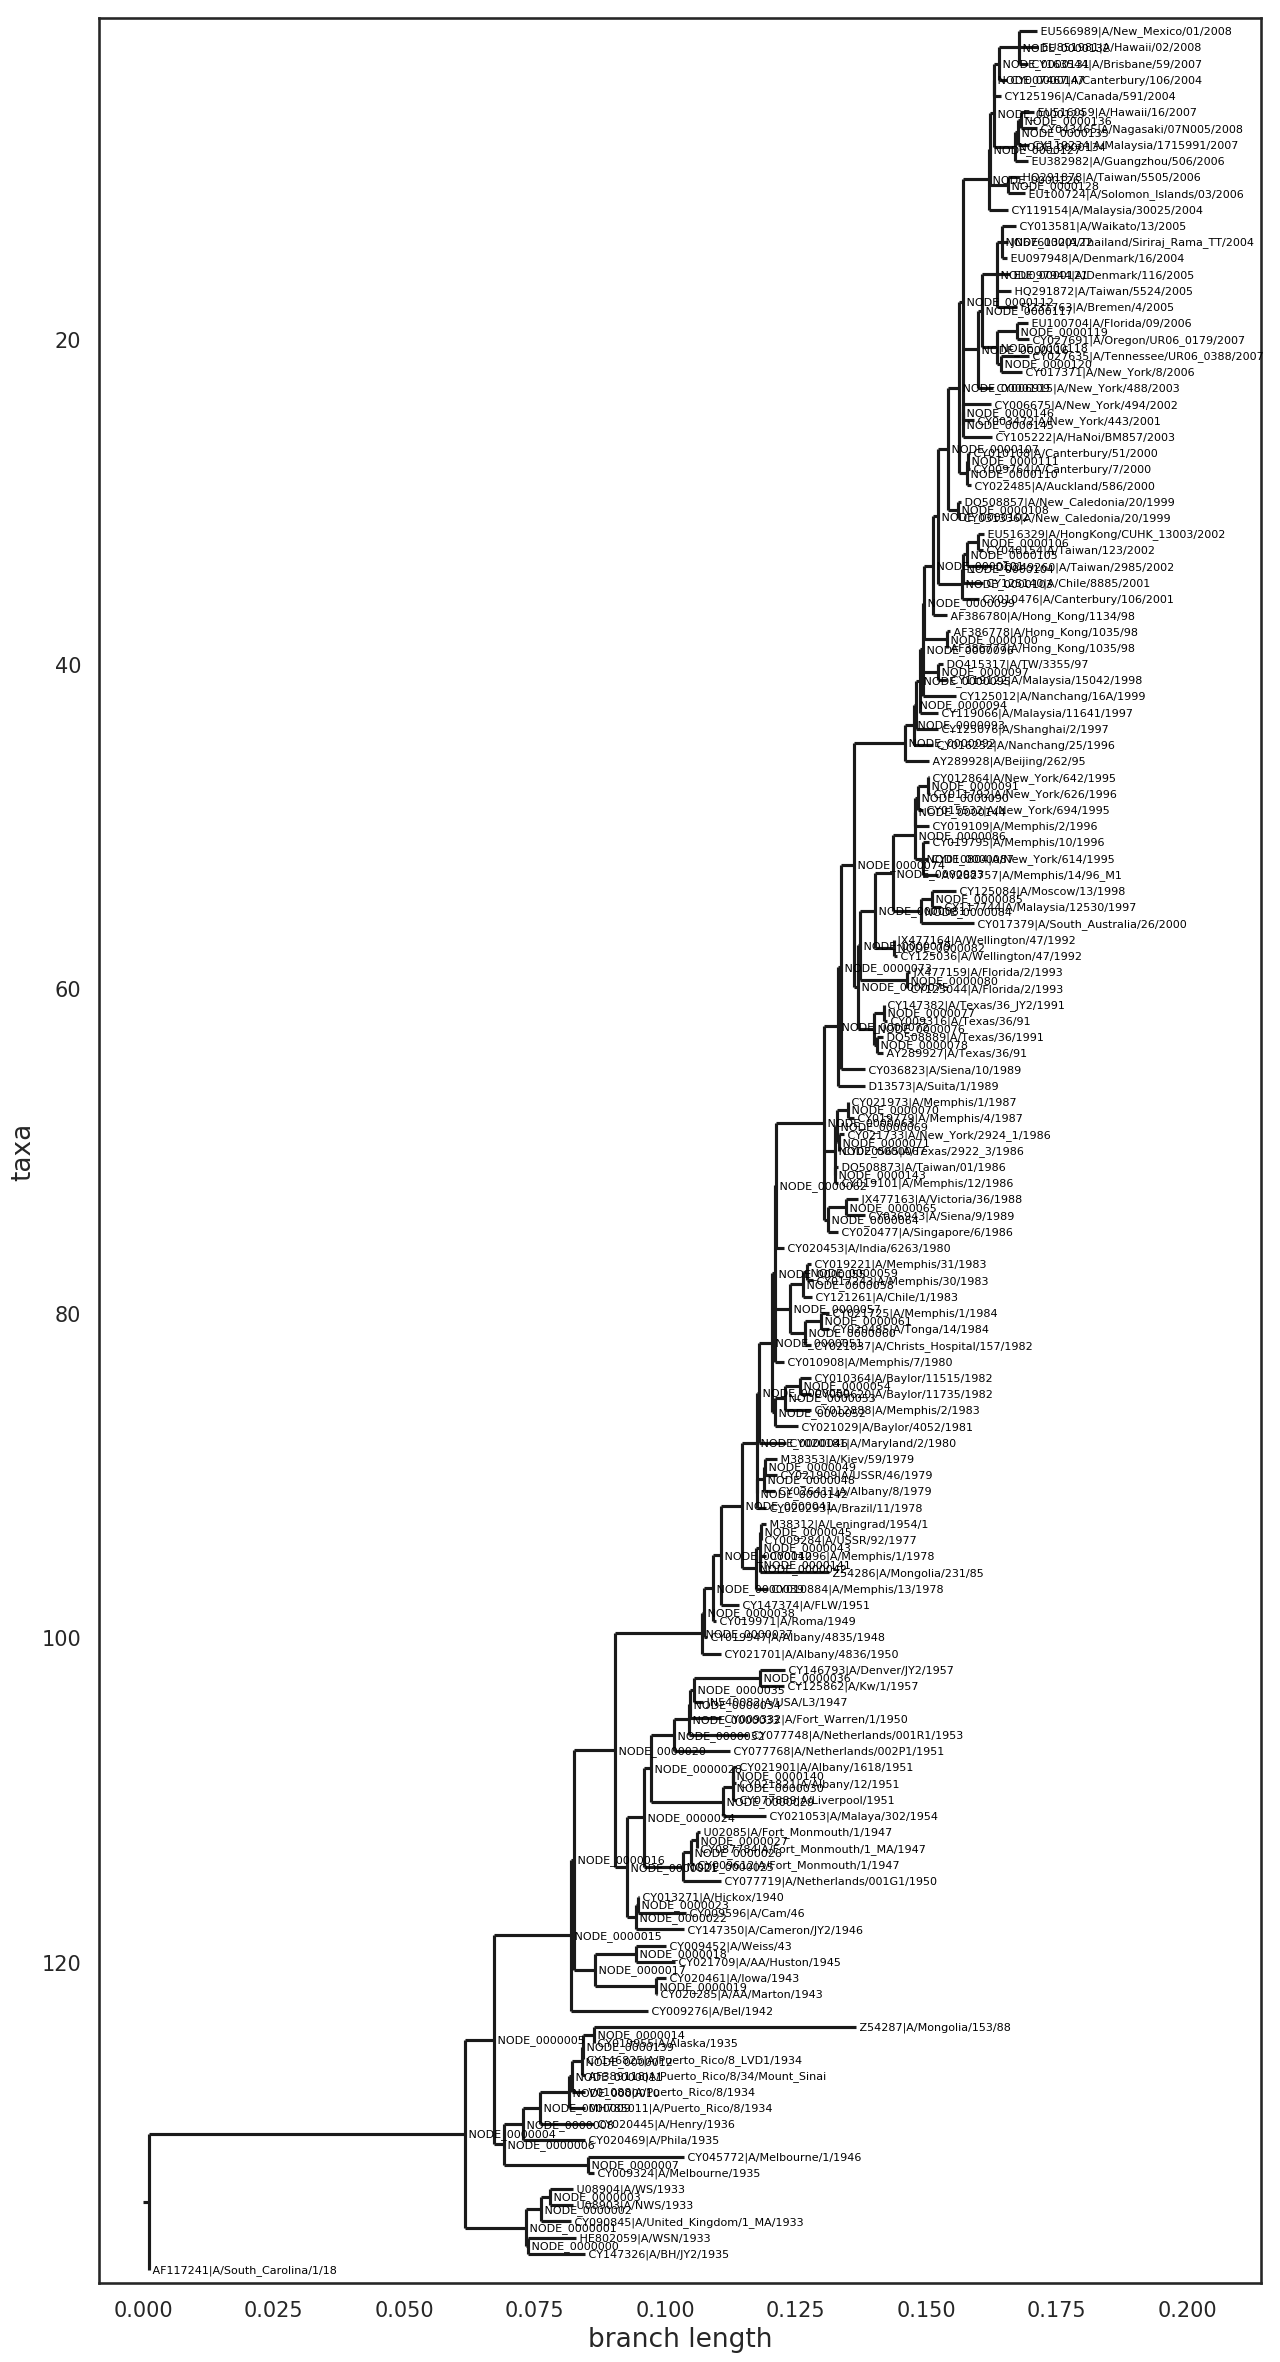

None


In [112]:
tree = Phylo.read("../results/tree-5_removed.nwk", "newick")
matplotlib.rc('font',size=8)
fig = plt.figure(figsize=(15,30), dpi=100)
axes=fig.add_subplot(1,1,1)
tree.ladderize(reverse=True)
tree.root_with_outgroup(outgroup_targets="AF117241|A/South_Carolina/1/18")
print(Phylo.draw(tree, axes=axes))

## Infer ancestral sequences

In [113]:
!augur ancestral \
  --tree ../results/tree-5_removed.nwk \
  --alignment ../results/aligned-5_removed.fasta \
  --output ../results/nt_muts-5_removed.json \
  --inference joint


Inferred ancestral sequence states using TreeTime:
	Sagulenko et al. TreeTime: Maximum-likelihood phylodynamic analysis
	Virus Evolution, vol 4, https://academic.oup.com/ve/article/4/1/vex042/4794731

ancestral sequences written to ../results/nt_muts-5_removed.json


## Identify amino acid mutations

### Translate NTs to AAs

In [2]:
# Get names and sequences from nt_muts-5.json

with open("../results/nt_muts-5_removed.json") as nt:
    nt_muts = json.load(nt)

strains = []
nt_seqs = []
for strain in nt_muts['nodes'].keys():
    strains.append(strain)

    nt_seqs.append(nt_muts['nodes'][strain]['sequence'])

aa_seqs = []
counter = 0
for seq in nt_seqs:
    aa_seqs.append(translate(seq, gap='-'))
    counter += 1
    
aa_strains = list(zip(strains, aa_seqs))


aa_strains_df = pd.DataFrame(data = aa_strains, columns=['strains', 'aa_seqs'], index = None)

aa_dict = aa_strains_df.set_index('strains').T.to_dict()


# set_index('ID').T.to_dict('list')

### Compare WSN and SC numbering 

In [4]:
with open("../results/nt_muts-5.json") as nt:
    nt_muts = json.load(nt)
    

ref_aa_seqs = []
ref_aa_seqs.append(aa_dict['AF117241|A/South_Carolina/1/18']['aa_seqs'])
ref_aa_seqs.append(aa_dict['HE802059|A/WSN/1933']['aa_seqs'])
# ref_aa_seqs.append('MKAFVLVLLYAFVATDADTICIGYHANNSTDTVDTIFEKNVAVTHSVNLLEDRHNGKLCKLKGIAPLQLGKCNITGWLLGNPECDSLLPARSWSYIVETPNSENGACYPGDFIDYEELREQLSSVSSLERFEIFPKESSWPNHTFNGVTVSCSHRGKSSFYRNLLWLTKKGDSYPKLTNSYVNNKGKEVLVLWGVHHPSSSDEQQSLYSNGNAYVSVASSNYNRRFTPEIAARPKVKDQHGRMNYYWTLLEPGDTIIFEATGNLIAPWYAFALSRGFESGIITSNASMHECNTKCQTPQGSINSNLPFQNIHPVTIGECPKYVRSTKLRMVTGLRNIPSIQYRGLFGAIAGFIEGGWTGMIDGWYGYHHQNEQGSGYAADQKSTQNAINRITNKVNSVIEKMNTQFTAVGKEFNNLEKRMENLNKKVDDGFLDIWTYNAELLVLLENERTLDFHDLNVKNLYEKVKSQLKNNAKEIGNGCFEFYHKCDNECMESVRNGTYDYPKYSEESKLNREKIDGVKLESMGVYQILAIYSTVASSLVLLVSLGAISFWMCSNGSLQCRICI')

ref_WSN_SC = {'AF117241|A/South_Carolina/1/18','HE802059|A/WSN/1933'}

AF117241_South_Carolina = {}
HE802059_WSN = {}
key = 1

for aa in ref_aa_seqs[0]:
    AF117241_South_Carolina[key] = aa
    key += 1

key = 1
for aa in ref_aa_seqs[1]:
    HE802059_WSN[key] = aa
    key += 1
    
for i in range(len(AF117241_South_Carolina)):
    if i+1 not in HE802059_WSN:
        HE802059_WSN[i+1] = None
    print(str(i+1) + ":" + AF117241_South_Carolina[i+1] + ', ' + HE802059_WSN[i+1])
# print(HE802059_WSN)

1:M, M
2:E, K
3:A, A
4:R, F
5:L, V
6:L, L
7:V, V
8:L, L
9:L, L
10:C, Y
11:A, A
12:F, F
13:A, V
14:A, A
15:T, T
16:N, D
17:A, A
18:D, D
19:T, T
20:I, I
21:C, C
22:I, I
23:G, G
24:Y, Y
25:H, H
26:A, A
27:N, N
28:N, N
29:S, S
30:T, T
31:D, D
32:T, T
33:V, V
34:D, D
35:T, T
36:V, I
37:L, F
38:E, E
39:K, K
40:N, N
41:V, V
42:T, A
43:V, V
44:T, T
45:H, H
46:S, S
47:V, V
48:N, N
49:L, L
50:L, L
51:E, E
52:D, D
53:S, R
54:H, H
55:N, N
56:G, G
57:K, K
58:L, L
59:C, C
60:K, K
61:L, L
62:K, K
63:G, G
64:I, I
65:A, A
66:P, P
67:L, L
68:Q, Q
69:L, L
70:G, G
71:K, K
72:C, C
73:N, N
74:I, I
75:A, T
76:G, G
77:W, W
78:L, L
79:L, L
80:G, G
81:N, N
82:P, P
83:E, E
84:C, C
85:D, D
86:L, S
87:L, L
88:L, L
89:T, P
90:A, A
91:S, R
92:S, S
93:W, W
94:S, S
95:Y, Y
96:I, I
97:V, V
98:E, E
99:T, T
100:S, P
101:N, N
102:S, S
103:E, E
104:N, N
105:G, G
106:T, A
107:C, C
108:Y, Y
109:P, P
110:G, G
111:D, D
112:F, F
113:I, I
114:D, D
115:Y, Y
116:E, E
117:E, E
118:L, L
119:R, R
120:E, E
121:Q, Q
122:L, L
123:S, S
1

### Trace tree

In [3]:
# for tip in tree, trace starting at tip and going to South_Carolina 1918 
tree = Phylo.read("../results/tree-5_removed.nwk", "newick")
traces = []
tips = []
for tip in tree.get_terminals():
    tips.append(tip)
    traces.append(tree.trace(start = tip, finish = "AF117241|A/South_Carolina/1/18"))
    
for trace in traces:
    for clade in trace:
        if clade.name == None:
            trace.remove(clade)

#### Stepwise distances from tip to parent until root

In [350]:
# for tip in tree, trace starting at tip and going to South_Carolina 1918 
tree = Phylo.read("../results/tree-5_removed.nwk", "newick")
traces = []
tips = []
for tip in tree.get_terminals():
    tips.append(tip)
    traces.append(tree.trace(start = tip, finish = "AF117241|A/South_Carolina/1/18"))
    
for trace in traces:
    for clade in trace:
        if clade.name == None:
            trace.remove(clade)


start_node = []
end_node = []
branch_id = []
branch_lengths = []
index = 0
for trace in traces:
    prev_node = tips[index].name
    for node in trace:
        branch_lengths.append(node.branch_length)
        start_node.append(prev_node)
        end_node.append(node.name)
        branch_id.append(tips[index].name)
        prev_node = node.name
    index += 1

# Pair strains to amino acid sequences in a dictionary
aa_strains_dict = {}
for key, value in aa_strains:
    aa_strains_dict[key] = value

# Compare sequences, store amino acid mutations in aa_muts list
aa_strains_dict
aa_muts = []
pos = 1
muts = []
for start, ref in zip(start_node, end_node):
    start_seq = aa_strains_dict[start]
    ref_seq = aa_strains_dict[ref]
    
    for aa1, aa2 in zip(start_seq, ref_seq):
        if aa1 == aa2:
#         print(aa1 + str(pos) + aa2)
            pos += 1
        if aa1 != aa2:
            muts.append(aa1 + str(pos) + aa2)
#         print(aa1 + str(pos) + aa2)
            pos += 1
    aa_muts.append(muts)
    muts = []
    pos = 1

stepwise_distances = list(zip(branch_id, start_node,end_node, branch_lengths, aa_muts))
dist_stepwise = pd.DataFrame(data = stepwise_distances, columns=['branch_id','start_node','end_node', 'branch_lengths', 'aa_muts'])
dist_stepwise.to_csv(r'../results/stepwise_mutations-5_removed.csv')


## Inchworm

#### Compare all combinations of all mutations for all node-node pairs

In [351]:
import itertools

b_lengths = []
s_node = []
e_node = []
b_id = []
itermuts = []
mut_pairs = []
position = 0
counter = 0
for row in aa_muts:
    if len(row) == 1:
        itermuts.append(row)
    else: 
        itermuts.append(list(itertools.combinations(row, 2)))
    
for i in itermuts:
    if not i:
        mut_pairs.append(None)
        b_lengths.append(branch_lengths[position])
        s_node.append(start_node[position])
        e_node.append(end_node[position])
        b_id.append(branch_id[position])
        position += 1
    elif len(i) == 1 and i[0] is not tuple:
        for p in i:
            mut_pairs.append(None)
            b_lengths.append(branch_lengths[position])
            s_node.append(start_node[position])
            e_node.append(end_node[position])
            b_id.append(branch_id[position])
        position += 1
  
    else :
        for p in i:
            mut_pairs.append(p)
            b_lengths.append(branch_lengths[position])
            s_node.append(start_node[position])
            e_node.append(end_node[position])
            b_id.append(branch_id[position])
        position += 1

stepwise_mut_pairs = list(zip(b_id, s_node,e_node, b_lengths, mut_pairs))
step_mut_pairs = pd.DataFrame(data = stepwise_mut_pairs, columns=['branch_id','start_node','end_node', 'branch_lengths', 'mut_pairs'])



#### Split mut_pairs

In [352]:
mut1 = []
mut2 = []
site1 = []
site2 = []

for pair in mut_pairs:
    if not pair:
        mut1.append(None)
        mut2.append(None)
        site1.append(None)
        site2.append(None)
    else:
        mut1.append(pair[0])
        mut2.append(pair[1])
        site1.append(pair[0][1:-1])
        site2.append(pair[1][1:-1])
        
stepwise_site_pairs = list(zip(b_id, s_node,e_node, b_lengths, mut1, mut2, site1, site2))
step_site_pairs_na = pd.DataFrame(data = stepwise_site_pairs, columns=['branch_id','start_node','end_node', 'branch_lengths', 'mut1', 'mut2', 'site1','site2'])

step_site_pairs_na

,branch_id,start_node,end_node,branch_lengths,mut1,mut2,site1,site2
0,AF117241|A/South_Carolina/1/18,AF117241|A/South_Carolina/1/18,AF117241|A/South_Carolina/1/18,0.027078,None,None,None,None
1,HE802059|A/WSN/1933,HE802059|A/WSN/1933,NODE_0000000,0.000389,F4R,V5L,4,5
2,HE802059|A/WSN/1933,HE802059|A/WSN/1933,NODE_0000000,0.000389,F4R,Y10C,4,10
3,HE802059|A/WSN/1933,HE802059|A/WSN/1933,NODE_0000000,0.000389,F4R,F12L,4,12
4,HE802059|A/WSN/1933,HE802059|A/WSN/1933,NODE_0000000,0.000389,F4R,V13A,4,13
5,HE802059|A/WSN/1933,HE802059|A/WSN/1933,NODE_0000000,0.000389,F4R,I36L,4,36
6,HE802059|A/WSN/1933,HE802059|A/WSN/1933,NODE_0000000,0.000389,F4R,F37L,4,37
7,HE802059|A/WSN/1933,HE802059|A/WSN/1933,NODE_0000000,0.000389,F4R,A42T,4,42
8,HE802059|A/WSN/1933,HE802059|A/WSN/1933,NODE_0000000,0.000389,F4R,R53S,4,53
9,HE802059|A/WSN/1933,HE802059|A/WSN/1933,NODE_0000000,0.000389,F4R,T75A,4,75


#### Remove redundant inchworms

In [353]:
redundant = []
index = 0
inchworm_rmred_na = pd.DataFrame()
for pair in zip(step_site_pairs_na['start_node'], step_site_pairs_na['end_node'], step_site_pairs_na['mut1'], step_site_pairs_na['mut2']):
    if pair not in redundant:
        redundant.append(pair)
        inchworm_rmred_na = inchworm_rmred_na.append(step_site_pairs_na.loc[index, :], ignore_index = True)
        index += 1
#         print(pair)
    else:
        index += 1
# print(len(set(step_site_pairs_na['branch_id'])))
# print(len(set(inchworm_rmred_na['branch_id'])))


inchworm = inchworm_rmred_na.dropna()
inchworm = inchworm.reset_index(drop=True)
print(len(set(inchworm['branch_id'])))
inchworm

55


,branch_id,branch_lengths,end_node,mut1,mut2,site1,site2,start_node
0,HE802059|A/WSN/1933,0.000389,NODE_0000000,F4R,V5L,4,5,HE802059|A/WSN/1933
1,HE802059|A/WSN/1933,0.000389,NODE_0000000,F4R,Y10C,4,10,HE802059|A/WSN/1933
2,HE802059|A/WSN/1933,0.000389,NODE_0000000,F4R,F12L,4,12,HE802059|A/WSN/1933
3,HE802059|A/WSN/1933,0.000389,NODE_0000000,F4R,V13A,4,13,HE802059|A/WSN/1933
4,HE802059|A/WSN/1933,0.000389,NODE_0000000,F4R,I36L,4,36,HE802059|A/WSN/1933
5,HE802059|A/WSN/1933,0.000389,NODE_0000000,F4R,F37L,4,37,HE802059|A/WSN/1933
6,HE802059|A/WSN/1933,0.000389,NODE_0000000,F4R,A42T,4,42,HE802059|A/WSN/1933
7,HE802059|A/WSN/1933,0.000389,NODE_0000000,F4R,R53S,4,53,HE802059|A/WSN/1933
8,HE802059|A/WSN/1933,0.000389,NODE_0000000,F4R,T75A,4,75,HE802059|A/WSN/1933
9,HE802059|A/WSN/1933,0.000389,NODE_0000000,F4R,T144N,4,144,HE802059|A/WSN/1933


#### Mutations per node-pair

In [354]:
# ggplot mutations per node-pair
num_muts = []
redundant = []
for row, pair in zip(aa_muts, zip(start_node, end_node)):
    if pair not in redundant:
        redundant.append(pair)
        num_muts.append(len(row))

num_muts_red = []
for row in aa_muts:
    num_muts_red.append(len(row))
    
num_muts_red_df = pd.DataFrame(num_muts_red, columns = ['mutations_per_branch'])
num_muts_df = pd.DataFrame(num_muts, columns = ['mutations_per_branch'])

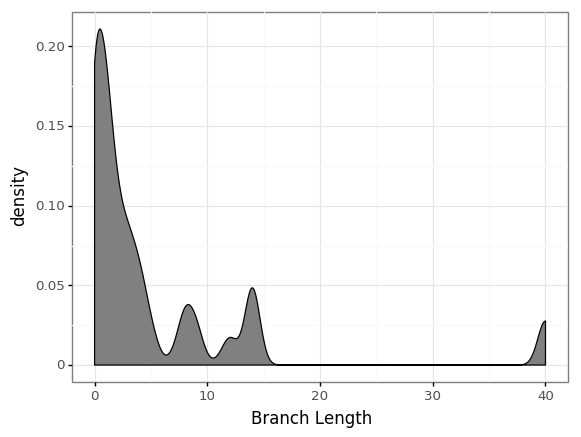

<ggplot: (8740702761999)>


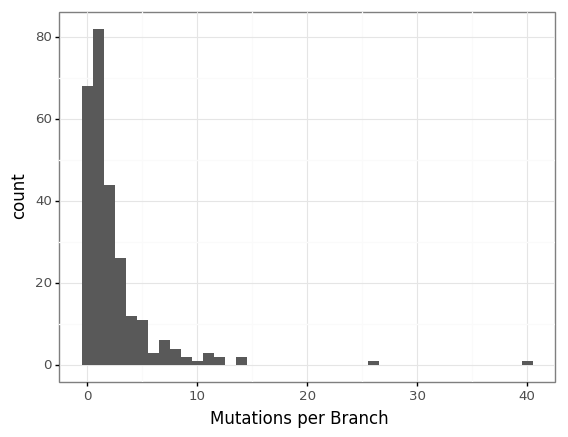

<ggplot: (-9223363296151949715)>


In [358]:
muts_per_branch_red = ggplot(num_muts_red_df, aes('mutations_per_branch')) + geom_density(fill = 'grey')+ labs(x = 'Branch Length')
print(muts_per_branch_red)

muts_per_branch = ggplot(num_muts_df, aes('mutations_per_branch')) + geom_histogram(binwidth=1) + labs(x = 'Mutations per Branch')
print(muts_per_branch)
muts_per_branch.save(filename="../figures/muts_per_branch.png")

#### Density of branch lengths

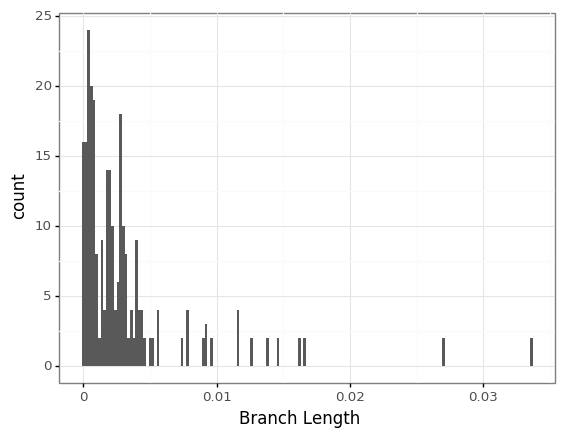

<ggplot: (8740297773667)>


In [365]:
num_blengths = []
redundant = []
for branch, pair in zip(branch_lengths, zip(start_node, end_node)):
    if pair not in redundant:
        redundant.append(pair)
        num_blengths.append(float(branch))
        
num_blengths_df = pd.DataFrame(num_blengths, columns = ['branch_lengths'])

blengths = ggplot(num_blengths_df, aes('branch_lengths')) + geom_histogram(binwidth=0.0002)+ labs(x = 'Branch Length')
blengths.save(filename="../figures/branch_length_distr.png")
print(blengths)

#### How many times do mutation sites occur?

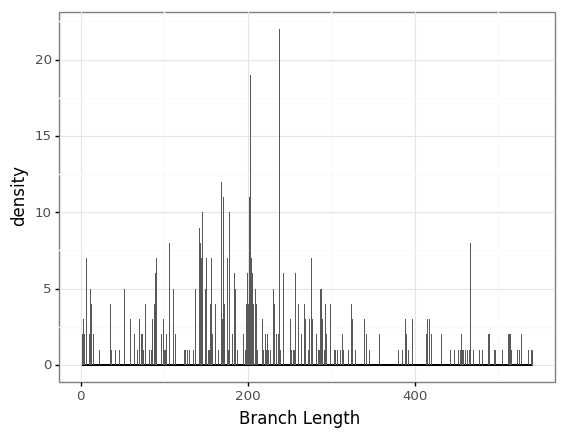

<ggplot: (-9223363296598232572)>


In [200]:
num_sites = []
redundant = []
for row, pair in zip(aa_muts, zip(start_node, end_node)):
    if pair not in redundant:
        redundant.append(pair)
        if row:
            for site in row:
                num_sites.append(int(site[1:-1]))
                
num_sites_df = pd.DataFrame(num_sites, columns = ['sites'])

numsites = (
    ggplot(num_sites_df, aes(x = 'sites')) 
    + labs(x = 'Branch Length') 
    + geom_density() 
    + stat_bin(binwidth=1)
)
# numsites.save(filename="../figures/num_sites.png")
print(numsites)  

#### Number of occurrences of site_pairs

In [9]:
inchworm['site_id'] = inchworm[['site1', 'site2']].apply(lambda x: "{0}_{1}".format(x[0], x[1]) if int(x[0]) < int(x[1]) else "{0}_{1}".format(x[1], x[0]), axis = 1)
inchworm

,branch_id,branch_lengths,end_node,mut1,mut2,site1,site2,start_node,site_id
0,HE802059|A/WSN/1933,0.000389,NODE_0000000,F4R,V5L,4,5,HE802059|A/WSN/1933,4_5
1,HE802059|A/WSN/1933,0.000389,NODE_0000000,F4R,Y10C,4,10,HE802059|A/WSN/1933,4_10
2,HE802059|A/WSN/1933,0.000389,NODE_0000000,F4R,F12L,4,12,HE802059|A/WSN/1933,4_12
3,HE802059|A/WSN/1933,0.000389,NODE_0000000,F4R,V13A,4,13,HE802059|A/WSN/1933,4_13
4,HE802059|A/WSN/1933,0.000389,NODE_0000000,F4R,I36L,4,36,HE802059|A/WSN/1933,4_36
5,HE802059|A/WSN/1933,0.000389,NODE_0000000,F4R,F37L,4,37,HE802059|A/WSN/1933,4_37
6,HE802059|A/WSN/1933,0.000389,NODE_0000000,F4R,A42T,4,42,HE802059|A/WSN/1933,4_42
7,HE802059|A/WSN/1933,0.000389,NODE_0000000,F4R,R53S,4,53,HE802059|A/WSN/1933,4_53
8,HE802059|A/WSN/1933,0.000389,NODE_0000000,F4R,T75A,4,75,HE802059|A/WSN/1933,4_75
9,HE802059|A/WSN/1933,0.000389,NODE_0000000,F4R,T144N,4,144,HE802059|A/WSN/1933,4_144


In [ ]:
inchworm_sitepair_count = inchworm.groupby(['site_id']).count()


count_temp = []
count_site_id = []
for name, group in inchworm.groupby(['site_id']):
    count_temp.append(name)
    count_temp.append(len(group))
    count_site_id.append(count_temp)
    count_temp = []

count_site_id_df = pd.DataFrame(count_site_id, columns = ['site_id','site_id_count'])    

/fh/fast/bloom_j/software/conda/envs/BloomLab_v2/lib/python3.6/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units))
/fh/fast/bloom_j/software/conda/envs/BloomLab_v2/lib/python3.6/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: ../figures/site_id_count.png
  warn('Filename: {}'.format(filename))


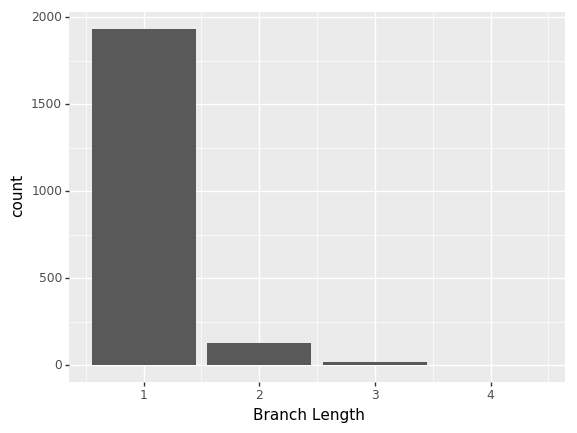

<ggplot: (-9223363296153149601)>

In [10]:
site_id_count = ggplot(count_site_id_df, aes(x='site_id_count')) + geom_bar(stat='count') + labs(x = 'Branch Length')
site_id_count.save(filename="../figures/site_id_count.png")
site_id_count

##### Add site_id_counts to dataframe

In [11]:
index = 0
inchworm['site_id_count'] = None
for site in inchworm['site_id']:
    for count in count_site_id:
        if site == count[0]:
            inchworm['site_id_count'].iat[index] = count[1]
    index += 1


### Distance matrix from PDB

In [12]:
from dms_tools2.protstruct import distMatrix as dM
equivs = {'B', 'C'}

dist_matrix = dM("../data/1RVX_trimer_sequentialnumbering.pdb",chains = "A", dist_type = "CA", equivchains = equivs)


site1List = inchworm['site1'].tolist()
site2List = inchworm['site2'].tolist()
dists = dist_matrix[1]

dist = []
for site1, site2 in zip(site1List, site2List):
    # The 18 and 502 need to be made generalizable
    # My PDB file starts at amino acid 18 and ends at 502
    if (int(site1) >= 18 and int(site1) <= 502) and (int(site2) >= 18 and int(site2) <= 502):
        # I subtract 18 below because the PDB starts at amino acid 18
        # but my distance matrix starts at index 0
        dist.append(dists[int(site1) - 18][int(site2) - 18])
    else:
        dist.append(None)
inchworm['dist'] = dist

#### Correlation plot

These colors suck. They're hard to see with the alpha (get rid of alpha?) and they're shitty for colorblind people

/fh/fast/bloom_j/software/conda/envs/BloomLab_v2/lib/python3.6/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units))
/fh/fast/bloom_j/software/conda/envs/BloomLab_v2/lib/python3.6/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: ../figures/inchworm_corrplot_color.png
  warn('Filename: {}'.format(filename))
/fh/fast/bloom_j/software/conda/envs/BloomLab_v2/lib/python3.6/site-packages/plotnine/layer.py:449: UserWarning: geom_point : Removed 450 rows containing missing values.
  self.data = self.geom.handle_na(self.data)
/fh/fast/bloom_j/software/conda/envs/BloomLab_v2/lib/python3.6/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units))
/fh/fast/bloom_j/software/conda/envs/BloomLab_v2/lib/python3.6/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: ../figures/inchworm_corrplot_alpha.png
  warn('Filename: {}'.format(filename))
/fh/fast/bloom_j/soft

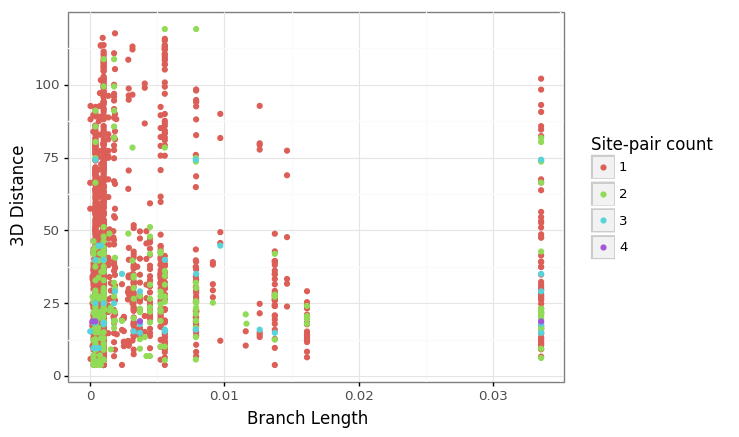

<ggplot: (8740485142413)>

In [22]:
inchworm_corrplot = ggplot(inchworm, aes(x = "branch_lengths", y = "dist")) + geom_point(aes(color='factor(site_id_count)')) + labs(x = 'Branch Length', y = '3D Distance', color = 'Site-pair count')
inchworm_corrplot.save(filename='../figures/inchworm_corrplot_color.png')

inchworm_corrplot_alpha = ggplot(inchworm, aes(x = "branch_lengths", y = "dist")) + geom_point(aes(color='factor(site_id_count)'), alpha=0.4) + labs(x = 'Branch Length', y = '3D Distance', color = 'Site-pair count')
inchworm_corrplot_alpha.save(filename='../figures/inchworm_corrplot_alpha.png')

inchworm_corrplot

Make a "scrambled" corrplot

## Concatworm

In [321]:
concatworm_blengths = []
start_n = []
end_n = []
concatworm_branch_id = []
index = 0
redun_check = []
start_end = []
red_start = []
red_end = []
repetition = []
# Lists for all start and end combinations from tip to root
for name, group in dist_stepwise.groupby("branch_id"):
    starts = group.start_node.unique()
    ends = group.end_node.unique()
    tip_id = starts[0]
    index = 0
    for start in starts:
        red_start.append(start)
        for end in ends[index:]:
            red_end.append(end)
            start_end.append(red_start)
            start_end.append(red_end)
            if start_end not in redun_check:
                concatworm_blengths.append(tree.distance(target1 = start, target2 = end))
                start_n.append(start)
                end_n.append(end)
                concatworm_branch_id.append(tip_id)
                redun_check.append(start_end)
                start_end = []
            repetition.append(start_end)
            start_end = []
            red_end = []
        red_start = []
        index += 1

# Mutations from each start to end
aa_muts = []
pos = 1
muts = []
for start, ref in zip(start_n, end_n):
    start_seq = aa_strains_dict[start]
    ref_seq = aa_strains_dict[ref]
    
    for aa1, aa2 in zip(start_seq, ref_seq):
        if aa1 == aa2:
#         print(aa1 + str(pos) + aa2)
            pos += 1
        if aa1 != aa2:
            muts.append(aa1 + str(pos) + aa2)
#         print(aa1 + str(pos) + aa2)
            pos += 1
    aa_muts.append(muts)
    muts = []
    pos = 1

In [25]:
catworm_mut_pairs = list(zip(concatworm_branch_id, start_n, end_n, concatworm_blengths, aa_muts))
catworm_mut_pairs_df = pd.DataFrame(data = catworm_mut_pairs, columns = ['branch_id', 'start_node','end_node', 'branch_lengths', 'aa_muts'])


In [26]:
# All combinations of mutations
catworm_b_lengths = []
catworm_s_node = []
catworm_e_node = []
catworm_b_id = []
catworm_itermuts = []
catworm_mut_pairs = []
position = 0
counter = 0
for row in aa_muts:
    if len(row) == 1:
        catworm_itermuts.append(row)
    else: 
        catworm_itermuts.append(list(itertools.combinations(row, 2)))

# Add annotation for each combination
for i in catworm_itermuts:
    if not i :
        catworm_mut_pairs.append(None)
        catworm_b_lengths.append(concatworm_blengths[position])
        catworm_s_node.append(start_n[position])
        catworm_e_node.append(end_n[position])
        catworm_b_id.append(concatworm_branch_id[position])
        position += 1
    elif len(i) == 1 and i[0] is not tuple:
        for p in i:
            catworm_mut_pairs.append(p)
            catworm_b_lengths.append(concatworm_blengths[position])
            catworm_s_node.append(start_n[position])
            catworm_e_node.append(end_n[position])
            catworm_b_id.append(concatworm_branch_id[position])
        position += 1
    else :
        for p in i:
            catworm_mut_pairs.append(p)
            catworm_b_lengths.append(concatworm_blengths[position])
            catworm_s_node.append(start_n[position])
            catworm_e_node.append(end_n[position])
            catworm_b_id.append(concatworm_branch_id[position])
        position += 1

stepwise_mut_comb = list(zip(catworm_b_id, catworm_s_node,catworm_e_node, catworm_b_lengths, catworm_mut_pairs))
step_mut_comb = pd.DataFrame(data = stepwise_mut_comb, columns=['catworm_branch_id','catworm_start_node','catworm_end_node', 'catworm_branch_lengths', 'catworm_mut_pairs'])


### Split mut_pairs

In [27]:
mut1 = []
mut2 = []
site1 = []
site2 = []

for pair in catworm_mut_pairs:
    if not pair:
        mut1.append(None)
        mut2.append(None)
        site1.append(None)
        site2.append(None)
    elif type(pair) != tuple:
        mut1.append(None)
        mut2.append(None)
        site1.append(None)
        site2.append(None)
    else:
        mut1.append(pair[0])
        mut2.append(pair[1])
        site1.append(pair[0][1:-1])
        site2.append(pair[1][1:-1])
        
catworm_mut_comb_pairs = list(zip(catworm_b_id, catworm_s_node,catworm_e_node, catworm_b_lengths, mut1, mut2, site1, site2))
catworm_mut_comb_pairs_na = pd.DataFrame(data = catworm_mut_comb_pairs, columns=['branch_id','start_node','end_node', 'branch_lengths', 'mut1', 'mut2', 'site1','site2'])

catworm_mut_comb_pairs_na


,branch_id,start_node,end_node,branch_lengths,mut1,mut2,site1,site2
0,AF117241|A/South_Carolina/1/18,AF117241|A/South_Carolina/1/18,AF117241|A/South_Carolina/1/18,0.000000,None,None,None,None
1,AF386777|A/Hong_Kong/1035/98,AF386777|A/Hong_Kong/1035/98,NODE_0000100,0.000000,None,None,None,None
2,AF386777|A/Hong_Kong/1035/98,AF386777|A/Hong_Kong/1035/98,NODE_0000099,0.004382,R53S,N197H,53,197
3,AF386777|A/Hong_Kong/1035/98,AF386777|A/Hong_Kong/1035/98,NODE_0000096,0.004614,R53S,N197H,53,197
4,AF386777|A/Hong_Kong/1035/98,AF386777|A/Hong_Kong/1035/98,NODE_0000095,0.005205,R53S,L86S,53,86
5,AF386777|A/Hong_Kong/1035/98,AF386777|A/Hong_Kong/1035/98,NODE_0000095,0.005205,R53S,N197H,53,197
6,AF386777|A/Hong_Kong/1035/98,AF386777|A/Hong_Kong/1035/98,NODE_0000095,0.005205,L86S,N197H,86,197
7,AF386777|A/Hong_Kong/1035/98,AF386777|A/Hong_Kong/1035/98,NODE_0000094,0.006074,R53S,L86S,53,86
8,AF386777|A/Hong_Kong/1035/98,AF386777|A/Hong_Kong/1035/98,NODE_0000094,0.006074,R53S,N197H,53,197
9,AF386777|A/Hong_Kong/1035/98,AF386777|A/Hong_Kong/1035/98,NODE_0000094,0.006074,R53S,D238G,53,238


### Drop NAs

In [29]:
catworm = catworm_mut_comb_pairs_na.dropna()
catworm = catworm.reset_index(drop=True)

#### Add site_id column

In [30]:
catworm['site_id'] = catworm[['site1', 'site2']].apply(lambda x: "{0}_{1}".format(x[0], x[1]) if int(x[0]) < int(x[1]) else "{0}_{1}".format(x[1], x[0]), axis = 1)


### Get minimum branch lengths

Group by mutation pairs (mut1, mut2), take the minimum branch length and put it in a new dataframe


**To keep the other columns**
1. idxmin() to get the index of the minimum
df.loc[df.groupby("item")["diff"].idxmin()]

1. sort then take the first entry
df.sort_values("diff").groupby("item", as_index=False).first()


In [31]:
catworm_min = catworm.sort_values("branch_lengths").groupby("site_id", as_index=False).first()

#### Mutations per node-pair

In [33]:
# ggplot mutations per node-pair
cat_num_muts = []
redundant = []
for row, pair in zip(aa_muts, zip(start_n, end_n)):
    if pair not in redundant:
        redundant.append(pair)
        cat_num_muts.append(len(row))


cat_num_muts_red = []
for row in aa_muts:
    cat_num_muts_red.append(len(row))
    

cat_num_muts_df = pd.DataFrame(cat_num_muts, columns = ['mutations_per_trace'])

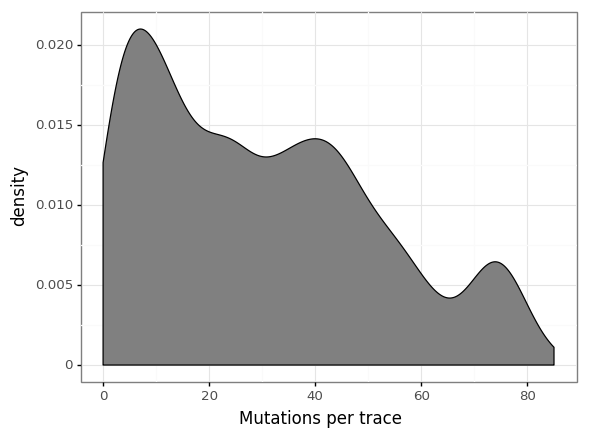

<ggplot: (8740299917320)>


/fh/fast/bloom_j/software/conda/envs/BloomLab_v2/lib/python3.6/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units))
/fh/fast/bloom_j/software/conda/envs/BloomLab_v2/lib/python3.6/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: ../figures/cat_muts_per_trace.png
  warn('Filename: {}'.format(filename))


In [35]:
cat_muts_per_branch = ggplot(cat_num_muts_df, aes('mutations_per_trace')) + geom_density(fill = 'grey') + xlab('Mutations per trace')
print(cat_muts_per_branch)
cat_muts_per_branch.save(filename="../figures/cat_muts_per_trace.png")

#### Density of branch lengths

In [324]:
cat_num_blengths = []

for branch in concatworm_blengths:
    cat_num_blengths.append(float(branch))
        
cat_num_blengths_df = pd.DataFrame(cat_num_blengths, columns = ['branch_lengths'])

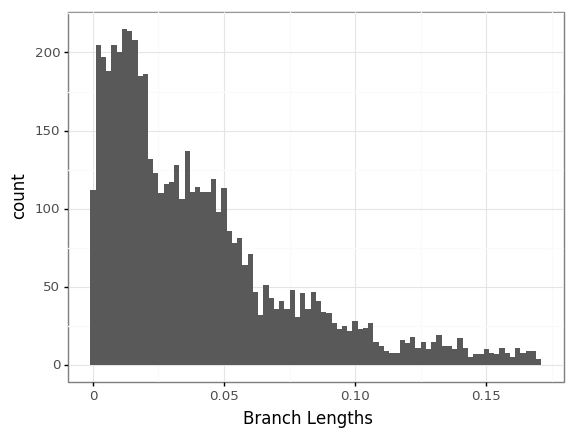

<ggplot: (-9223363296598125792)>


In [341]:
cat_blengths = ggplot(cat_num_blengths_df, aes('branch_lengths')) + stat_bin(binwidth=0.002) + xlab('Branch Lengths')
cat_blengths.save(filename="../figures/cat_branch_length_distr.png")
print(cat_blengths)

### Distance matrix from PDB

In [37]:
from dms_tools2.protstruct import distMatrix as dM
equivs = {'B', 'C'}

dist_matrix = dM("../data/1RVX_trimer_sequentialnumbering.pdb",chains = "A", dist_type = "CA", equivchains = equivs)


site1List = catworm_min['site1'].tolist()
site2List = catworm_min['site2'].tolist()
dists = dist_matrix[1]

dist = []
for site1, site2 in zip(site1List, site2List):
    # The 18 and 502 need to be made generalizable
    # My PDB file starts at amino acid 18 and ends at 502
    if (int(site1) >= 18 and int(site1) <= 502) and (int(site2) >= 18 and int(site2) <= 502):
        # I subtract 18 below because the PDB starts at amino acid 18
        # but my distance matrix starts at index 0
        dist.append(dists[int(site1) - 18][int(site2) - 18])
    else:
        dist.append(None)
catworm_min['dist'] = dist

/fh/fast/bloom_j/software/conda/envs/BloomLab_v2/lib/python3.6/site-packages/plotnine/layer.py:449: UserWarning: geom_point : Removed 2611 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


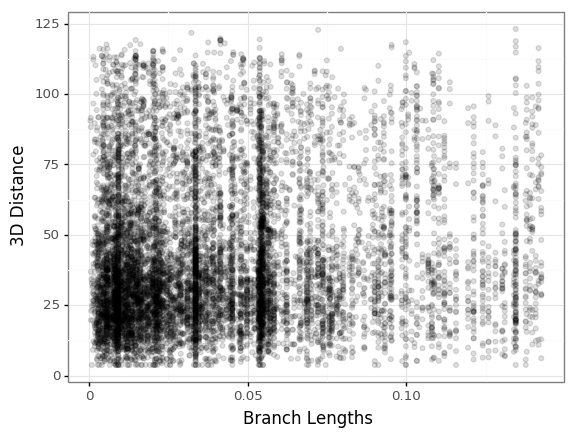

<ggplot: (8740299942043)>


/fh/fast/bloom_j/software/conda/envs/BloomLab_v2/lib/python3.6/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units))
/fh/fast/bloom_j/software/conda/envs/BloomLab_v2/lib/python3.6/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: ../figures/catworm_corrplot.png
  warn('Filename: {}'.format(filename))
/fh/fast/bloom_j/software/conda/envs/BloomLab_v2/lib/python3.6/site-packages/plotnine/layer.py:449: UserWarning: geom_point : Removed 2611 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


In [38]:
catworm_corrplot = ggplot(catworm_min, aes(x = "branch_lengths", y = "dist")) + geom_point(alpha = 0.13) + xlab('Branch Lengths') + ylab('3D Distance')
print(catworm_corrplot)
catworm_corrplot.save(filename='../figures/catworm_corrplot.png')


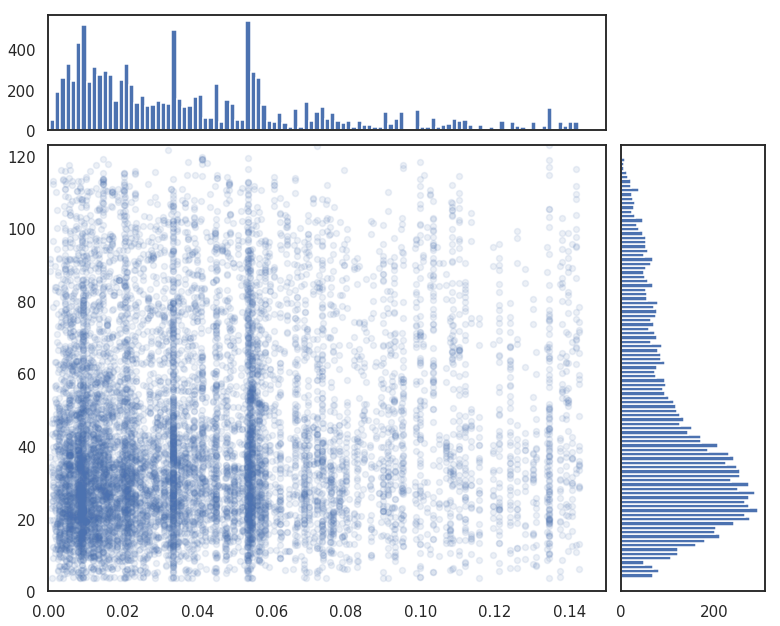

<Figure size 432x288 with 0 Axes>

In [39]:
from matplotlib.ticker import NullFormatter

catworm_plt = catworm_min[['branch_lengths', 'dist']].copy()
catworm_plt = catworm_plt.dropna()

nullfmt = NullFormatter()         # no labels

# fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(10, 8))
# axes.plot(catworm_plt['branch_lengths'], catworm_plt['dist'],'ko', alpha=0.1)


x=catworm_plt['branch_lengths']
y=catworm_plt['dist']




left, width = 0.125, 0.775
bottom, height = 0.12, 0.775
bottom_h = left_h = left + width + 0.02

rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]
rect_scatter = [left, bottom, width, height]

plt.figure(1, figsize=(10, 8))


axScatter = plt.axes(rect_scatter)

axScatter.scatter(x, y, s=35, alpha = 0.1)

axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)

axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)

binwidth = 0.75

axScatter.set_xlim((0, 0.15))
axScatter.set_ylim((0, 123))

axHistx.hist(x, bins=100)
axHisty.hist(y, bins=100, orientation='horizontal')

axHistx.set_xlim(axScatter.get_xlim()) 
axHisty.set_ylim(axScatter.get_ylim()) 

plt.show()
plt.savefig('../figures/catworm_scatter-histo.png', dpi=300)

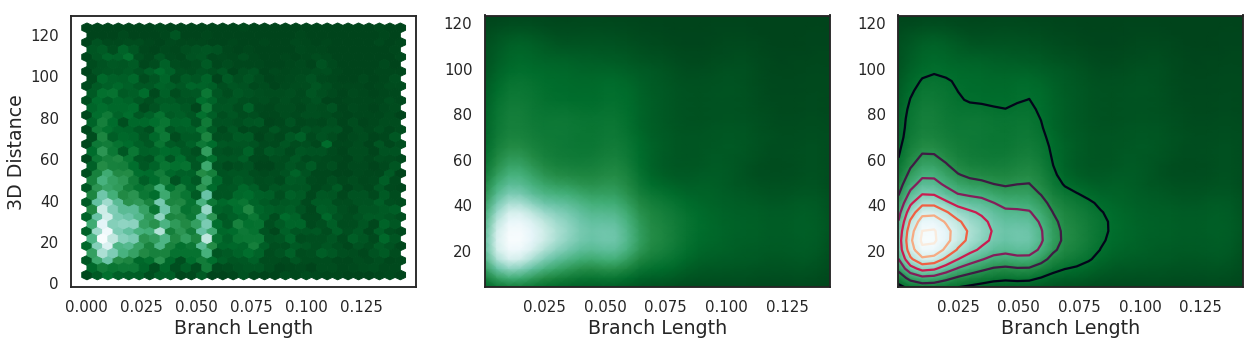

In [40]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(21, 5))


# Thus we can cut the plotting window in several hexbins
nbins = 30
axes[0].hexbin(catworm_plt['branch_lengths'], catworm_plt['dist'], gridsize=nbins, cmap=plt.cm.BuGn_r)
axes[0].set_xlabel('Branch Length')
axes[0].set_ylabel('3D Distance')

# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
k = kde.gaussian_kde(catworm_plt.T)
xi, yi = np.mgrid[catworm_plt['branch_lengths'].min():catworm_plt['branch_lengths'].max():nbins*1j, catworm_plt['dist'].min():catworm_plt['dist'].max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
 
# add shading
axes[1].pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.BuGn_r)
axes[1].set_xlabel('Branch Length')


# contour
axes[2].pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.BuGn_r)
axes[2].contour(xi, yi, zi.reshape(xi.shape) )
axes[2].set_xlabel('Branch Length')

plt.savefig('../figures/catworm_2d_density.png', dpi=300)

### Bin data

#### Bin by nbins

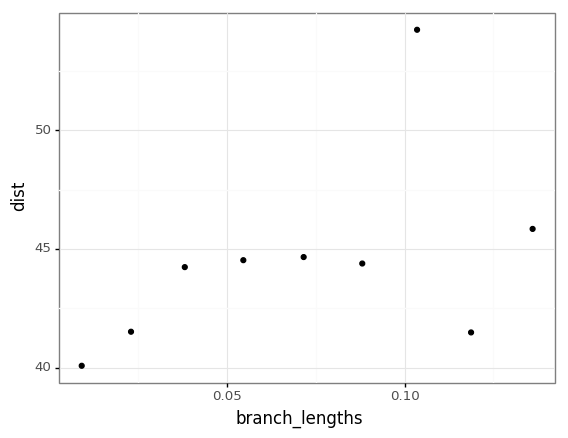

<ggplot: (8740297534419)>

In [92]:
catworm_plt
nbins = 10
catmin = catworm_plt.branch_lengths.min()
catmax = catworm_plt.branch_lengths.max()

bins = np.linspace(catmin, catmax, num=nbins)

catworm_bin = catworm_plt.groupby(pd.cut(catworm_plt.branch_lengths, bins))
catworm_bin_avg = catworm_bin.mean()

catbin_index = catworm_bin_avg.reset_index(drop=True)
# catbin_index
# ggplot(catbin_index, aes(x='branch_lengths', y='dist')) + geom_point()

#### Bin by quantile

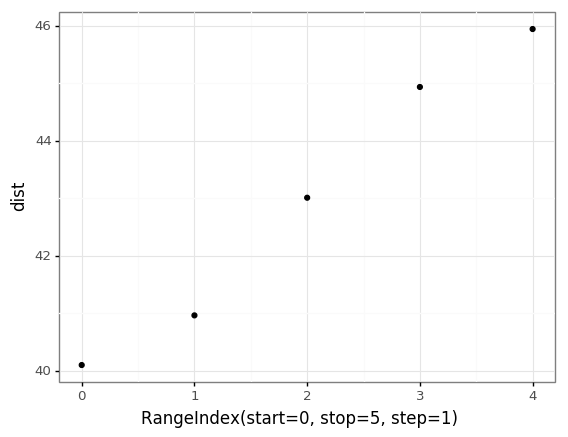

<ggplot: (-9223363296598042266)>


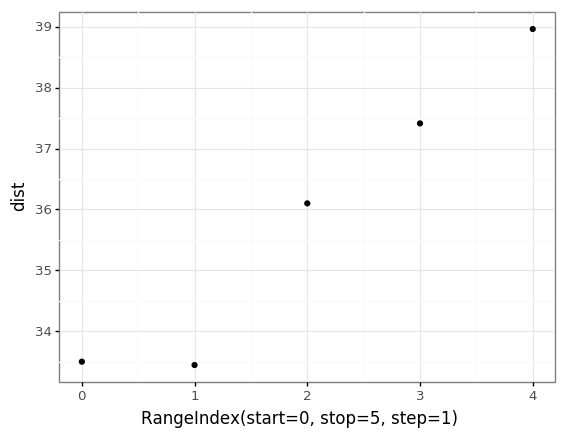

<ggplot: (8740257113734)>


In [239]:
catworm_quint = catworm_plt.groupby(pd.qcut(x=catworm_plt.branch_lengths, q=5))
catworm_quint_avg = catworm_quint.mean().reset_index(drop=True)
catworm_quint_med = catworm_quint.median().reset_index(drop=True)

avg_cat = ggplot(catworm_quint_avg, aes(x=catworm_quint_avg.index, y='dist')) + geom_point()
med_cat = ggplot(catworm_quint_med, aes(x=catworm_quint_med.index, y='dist')) + geom_point()

print(avg_cat)
print(med_cat)


#### Shuffle data
Bin after shuffle

In [107]:
catworm_slim = catworm_min[['branch_lengths','dist','site_id']].copy()

Grouped by average

In [273]:
import warnings 
warnings.filterwarnings('ignore')

reps = 1000
np.random.seed(0)

catshuffle = catworm_slim
catshuffle = catshuffle.dropna()


# Turn df into numpy array
npcat = catshuffle['branch_lengths'].values

tempList=[]
final_avg = []
temp = pd.DataFrame
for rep in range(0,reps):
    
    

    # Shuffle
    np.random.shuffle(npcat)

    # Reassign 'branch_lengths' as shuffled list
    catshuffle['branch_lengths'] = npcat

    catshuffle_bin = catshuffle.groupby(pd.qcut(x=catshuffle.branch_lengths, q=5))
    temp = pd.DataFrame(catshuffle_bin.mean().reset_index(drop=True))
    temp['rep'] = rep + 1
    final_avg.append(temp)

final_avg = pd.concat(final_avg)

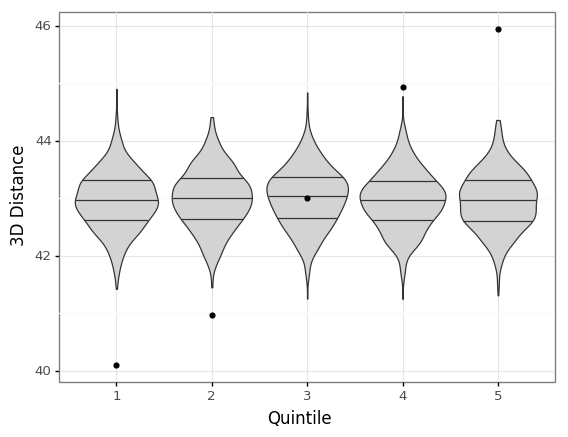

<ggplot: (-9223363296557254007)>


In [288]:
final_avg['quint'] = final_med.index + 1
catworm_quint_avg['quint'] = catworm_quint_med.index + 1


cat_quint_avg = (
    ggplot(final_avg, aes('factor(final_avg.quint)', 'dist'))
    + geom_violin(fill='lightgrey', draw_quantiles=(0.25, 0.5, 0.75)) 
    + labs(x='Quintile', y='3D Distance')
    + geom_point(aes('factor(catworm_quint_avg.quint)', catworm_quint_avg.dist), data=catworm_quint_avg)
)

print(cat_quint_avg)
cat_quint_avg.save(filename='../figures/cat_quint_avg.png')
avg_rando = (
    ggplot(final_avg, aes('factor(final_avg.quint)', 'dist'))
    + geom_violin(fill='lightgrey', draw_quantiles=(0.25, 0.5, 0.75)) 
    + labs(x='Quintile', y='3D Distance')
)

# Need to scale y's to be the same to get a naked rando plot

Plot catworm quintiles with appropriate y-axis limits

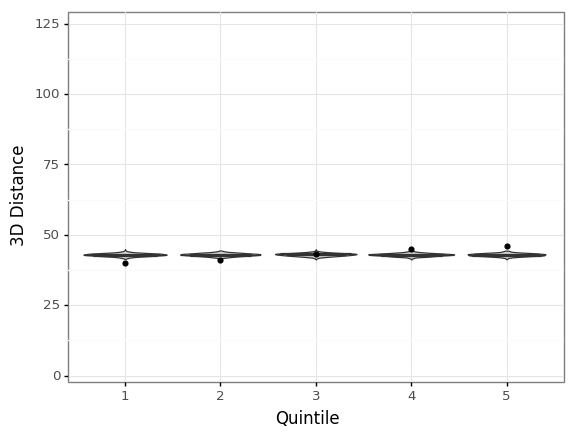

<ggplot: (8740298263272)>


In [312]:
max = catworm_min.dist.max()
min = catworm_min.dist.min()

cat_quint_avg_yscale = (
    ggplot(final_avg, aes('factor(final_avg.quint)', 'dist'))
    + geom_violin(fill='lightgrey', draw_quantiles=(0.25, 0.5, 0.75)) 
    + labs(x='Quintile', y='3D Distance')
    + geom_point(aes('factor(catworm_quint_avg.quint)', catworm_quint_avg.dist), data=catworm_quint_avg)
    + lims(y=(min, max))
)
print(cat_quint_avg_yscale)
cat_quint_avg_yscale.save(filename='../figures/cat_quint_avg_yscale.png')



Grouped by median

In [276]:
import warnings 
warnings.filterwarnings('ignore')

reps = 1000
np.random.seed(0)

catshuffle = catworm_slim
catshuffle = catshuffle.dropna()


# Turn df into numpy array
npcat = catshuffle['branch_lengths'].values

tempList=[]
final_med = []
temp = pd.DataFrame
for rep in range(0,reps):
    
    

    # Shuffle
    np.random.shuffle(npcat)

    # Reassign 'branch_lengths' as shuffled list
    catshuffle['branch_lengths'] = npcat

    catshuffle_bin = catshuffle.groupby(pd.qcut(x=catshuffle.branch_lengths, q=5))
    temp = pd.DataFrame(catshuffle_bin.median().reset_index(drop=True))
    temp['rep'] = rep + 1
    final_med.append(temp)

final_med = pd.concat(final_med)

Plot averages violin plot

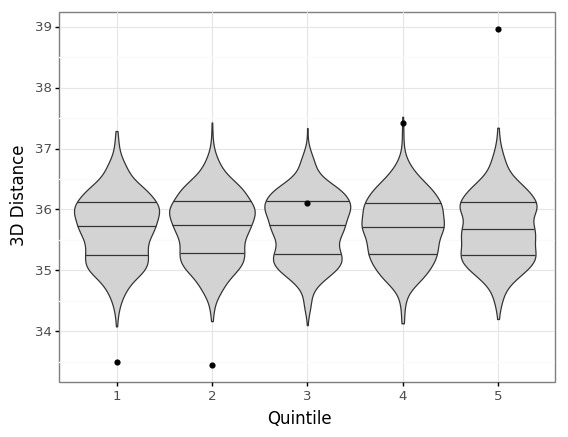

<ggplot: (-9223363296598121805)>


In [282]:
final_med['quint'] = final_med.index + 1
catworm_quint_med['quint'] = catworm_quint_med.index + 1

cat_quint_med = (
    ggplot(final_med, aes('factor(final_med.quint)', 'dist'))
    + geom_violin(fill='lightgrey', draw_quantiles=(0.25, 0.5, 0.75)) 
    + labs(x='Quintile', y='3D Distance')
    + geom_point(aes(x = 'factor(catworm_quint_med.quint)', y=catworm_quint_med.dist), data=catworm_quint_med, )
)

print(cat_quint_med)
cat_quint_med.save(filename='../figures/cat_quint_med.png')

Plot catworm quintiles with appropriate y-axis limits

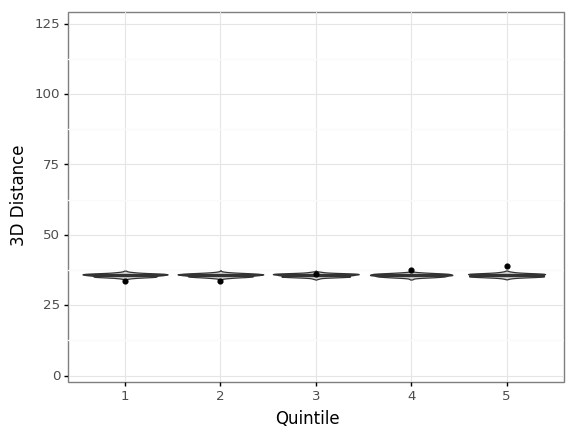

<ggplot: (8740297827974)>


In [316]:
max = catworm_min.dist.max()
min = catworm_min.dist.min()

cat_quint_med_yscale = (
    ggplot(final_med, aes('factor(final_med.quint)', 'dist'))
    + geom_violin(fill='lightgrey', draw_quantiles=(0.25, 0.5, 0.75)) 
    + labs(x='Quintile', y='3D Distance')
    + geom_point(aes(x = 'factor(catworm_quint_med.quint)', y=catworm_quint_med.dist), data=catworm_quint_med)
    + lims(y=(min, max))
)

print(cat_quint_med_yscale)
cat_quint_med_yscale.save(filename='../figures/cat_quint_med_yscale.png')


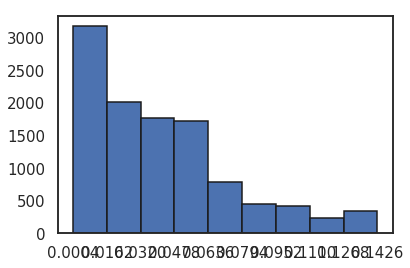

In [49]:
nbins = 10
catmin = catworm_plt.branch_lengths.min()
catmax = catworm_plt.branch_lengths.max()

bins = np.linspace(catmin, catmax, num=nbins)

plt.hist(catworm_plt.branch_lengths, bins=bins, edgecolor="k")
plt.xticks(bins)

plt.show()

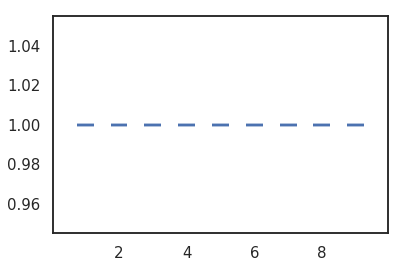

In [62]:
plt.violinplot(catworm_bin, points=20, widths=1,
                      showmeans=True, showextrema=True, showmedians=True)

plt.show()